In [1]:
import os
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

# Delft3D-flow Output File

Open the file and inspect the metadata

In [2]:
nc = netCDF4.Dataset("example.nc")
print(nc)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6 SGRID-0.3
    institution: Deltares
    references: www.deltares.nl
    source: Deltares, FLOW2D3D Version 6.03.00.62434, Oct 24 2018, 15:24:39
    history: This file is created on 2024-08-10T09:12:24-0000, Delft3D
    LAYER_MODEL: Z-MODEL
    dimensions(sizes): NC(36), MC(182), N(36), M(182), strlen20(20), LSTSCI(1), LTUR(2), K_LYR(100), K_INTF(101), KMAXOUT(101), KMAXOUT_RESTR(100), time(56), length_7(7), NSRC(5)
    variables(dimensions): float64 XCOR(MC, NC), float64 YCOR(MC, NC), float64 XZ(M, N), float64 YZ(M, N), float32 ALFAS(M, N), int32 KCU(MC, N), int32 KCV(M, NC), int32 KCS(M, N), float32 DP0(MC, NC), float32 DPS0(M, N), float32 DPU0(MC, N), float32 DPV0(M, NC), |S1 NAMCON(LSTSCI, strlen20), |S1 NAMTUR(LTUR, strlen20), float32 ZK_LYR(K_LYR), float32 ZK(K_INTF), float32 GSQS(M, N), int32 PPARTITION(M, N), int32 KMAXOUT(KMAXOUT), int32 KMAXOUT_RESTR(KMAXOUT_RESTR), fl

There are a large number of dimensions and variables included in the file. The following code extracts the most commonly used variables (temperature and velocity) but a description of all dimensions and variables is available at the bottom of the notebook.

## Plot results

In [3]:
depth = 1
time = datetime(2024, 8, 7, 14, 30)

In [4]:
def get_closest_index(value, array):
    array = np.asarray(array)
    sorted_array = np.sort(array)
    if len(array) == 0:
        raise ValueError("Array must be longer than len(0) to find index of value")
    elif len(array) == 1:
        return 0
    if value > (2 * sorted_array[-1] - sorted_array[-2]):
        raise ValueError("Value {} greater than max available ({})".format(value, sorted_array[-1]))
    elif value < (2 * sorted_array[0] - sorted_array[-1]):
        raise ValueError("Value {} less than min available ({})".format(value, sorted_array[0]))
    return (np.abs(array - value)).argmin()

In [5]:
def convert_time(time):
    return datetime.utcfromtimestamp(time + (datetime(2008, 3, 1).replace(tzinfo=timezone.utc) - datetime(1970, 1, 1).replace(tzinfo=timezone.utc)).total_seconds())

In [6]:
depth_index = get_closest_index(depth, np.array(nc.variables["ZK_LYR"][:]) * -1)
time_converted_units = (time - datetime(2008, 3, 1, 0, 0, 0)).total_seconds()
time_index = get_closest_index(time_converted_units, np.array(nc.variables["time"][:]))

### Temperature

The plots are distorted by the lack of inclusion of global coordinates, these can be accessed in the XZ and YZ variables.

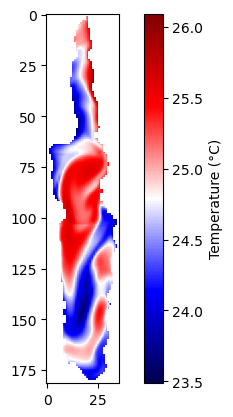

In [7]:
temperature = np.array(nc.variables["R1"][time_index, 0, depth_index, :])
temperature[temperature == -999] = np.nan
plt.imshow(temperature, cmap='seismic')
plt.colorbar(label="Temperature (°C)")

### Velocity

It is necessary to rotate the velocities from a grid reference system to a global reference system using ALFAS

In [8]:
def rotate_velocity(u, v, alpha):
    u = np.asarray(u).astype(np.float64)
    v = np.asarray(v).astype(np.float64)
    alpha = np.asarray(alpha).astype(np.float64)
    
    u[u == -999.0] = np.nan
    v[v == -999.0] = np.nan
    alpha[alpha == 0.0] = np.nan

    alpha = np.radians(alpha)
    u_n = u * np.cos(alpha) - v * np.sin(alpha)
    v_e = v * np.cos(alpha) + u * np.sin(alpha)

    return u_n, v_e

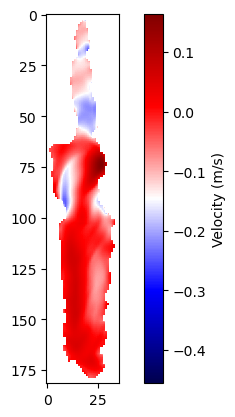

In [9]:
u, v, = rotate_velocity(nc.variables["U1"][time_index, depth_index, :],
                        nc.variables["V1"][time_index, depth_index, :],
                        np.array(nc.variables["ALFAS"][:]))
velocity_magintude = ( u * 2 + v * 2 ) * 0.5
plt.imshow(velocity_magintude, cmap='seismic')
plt.colorbar(label="Velocity (m/s)")

## Dimensions and variables

| Dimension | Description |
| :------- | :--------- |
| NC | number of grid cell corners in the η (==V) direction |
| MC | number of grid cell corners in the ξ (==U) direction |
| N | number of grid cell centers in the V direction |
| M | number of grid cell centers in the U direction |
| strlen20 | number of characters in string variables |
| LSTSCI | Number of Constituents (Salinity, Temperature, Sediment, Conservative Constituents and Secondary Flow) |
| LTUR | Flag for 3D turbulence model, also denoting the number of turbulent energy constituents (0 = Algebraic model, 1 = k-l model, 2 = k-eps model |
| K_LYR | number of layers |
| K_INTF | number of layers interfaces (K_LYR + 1) |
| KMAXOUT | number of layer interfaces |
| KMAXOUT_RESTR | number of layer interfaces |
| time | number of timestep stored in seconds since Itdate (in .mdf file, reference date of the simulation). |

| Variable | Description |
| :------- |  :--------- |
| XCOR(MC, NC) | East coordinate of grid cell corners |
| YCOR(MC, NC) | North coordinate of grid cell corners |
| XZ(M, N) | East coordinate of grid cell centers (zeta points) |
| YZ(M, N) | North coordinate of grid cell centers (zeta points) |
| ALFAS(M, N) | orientation of ξ axis (i.e. local x axis where U is defined) with respect to the x-axis (East) defined in the Z points. Positive clockwise, so alpha=0 🡪 ξ aligned with x, hence V velocities point towards North, 90 🡪 with V point towards East; 180 🡪 V pointing towards South;  |
| KCU(MC, N) | Mask array for U velocity points: this matrix shows 1 more unmasked column at each row (columns dimension is N == η (V) direction, no boundary conditions in this direction for U |
| KCV(M, NC) | Mask array for V velocity points: this matrix shows 1 more unmasked row at each column (rows dimension is M == ξ (U) direction, no boundary conditions in this direction for V |
| KCS(M, N) | Active/non active water level points |
| DP0(MC, NC) | Initial bottom depth at grid cell corners |
| DPS0(M, N) | Initial bottom depth at zeta points |
| DPU0(MC, N) | Initial bottom depth at U points |
| DPV0(M, NC) | Initial bottom depth at V points |
| S1 NAMCON(LSTSCI, strlen20) | Name of constituents (e.g. Temperature, Salinity, Passive tracers names given by the user). S1 indicates that these constituents are defined (horizontally) in water level/zeta points |
| S1 NAMTUR(LTUR, strlen20) | Name of turbulent quantities (e.g. Turbulent energy, Energy dissipation). S1 indicates that these constituents are defined (horizontally) in water level/zeta points |
| ZK_LYR(K_LYR) | vertical coordinate of layer center |
| ZK(K_INTF) | vertical coordinate of layer interfaces |
| GSQS(M, N) | Horizontal area of computational cell  |
| PPARTITION(M, N) | Partition to which each grid cell is associated in the domain decomposition (0 to 5 for Lake Joux case because I used 6 cpus per simulation) |
| KMAXOUT(KMAXOUT) | Number of layer interfaces |
| KMAXOUT_RESTR(KMAXOUT_RESTR) | Number of layer centers |
| RHOCONST() | User specified constant density  |
| GRAVITY() | Gravitational acceleration |
| time(time) | time in seconds since Itdate (in .mdf file, reference date of the simulation). |
| S1(time, M, N) | water level in z points |
| KFU(time, MC, N) | active/non active U points (it might be the same as KCU, but here we have the introduction of time including the possibility that some points might become active/non active due to drying and flooding) |
| KFV(time, M, NC) | active/non active V points (it might be the same as KCV, but here we have the introduction of time including the possibility that some points might become active/non active due to drying and flooding) |
| U1(time, KMAXOUT_RESTR, MC, N) | u velocity per layer in U points |
| V1(time, KMAXOUT_RESTR, M, NC) | v velocity per layer in V points |
| W(time, KMAXOUT, M, N)  | ω (vertical velocity) per layer at layer interfaces  |
| WPHY(time, KMAXOUT_RESTR, M, N) | ω (vertical velocity) per layer at layer center. In principle, WPHY = 0.5*(w[:,1:,:,:] + w[:,:-1,:,:]) |
| R1(time, LSTSCI, KMAXOUT_RESTR, M, N) | Concentrations of constituents per layer in z points and at layer centers. |
| RTUR1(time, LTUR, KMAXOUT, M, N) | Turbulent quantities per layer in z points and at layer interfaces. |
| TAUKSI(time, MC, N) | Bottom stress in U points (ξ direction) |
| TAUETA(time, M, NC) | Bottom stress in V points (η direction) |
| TAUMAX(time, M, N) | Maximum bottom stress in z points |
| VICWW(time, KMAXOUT, M, N) | Vertical eddy viscosity in z points at layer interfaces |
| DICWW(time, KMAXOUT, M, N) | Vertical eddy diffusivity in z points at layer interfaces |
| RICH(time, KMAXOUT, M, N) | Richardson number in z points at layer interfaces |
| RHO(time, KMAXOUT_RESTR, M, N) | Density (computed with Unesco formulation from Temperature and Salinity) in z points at layer centers |
| UMNLDF(time, MC, N) | Filtered U velocity (after Forester filter application) |
| VMNLDF(time, M, NC) | Filtered V velocity (after Forester filter application) |
| VICUV(time, KMAXOUT_RESTR, M, N) | Horizontal eddy viscosity in Z points and layer centers |
| HYDPRES(time, KMAXOUT_RESTR, M, N) | Hydrostatic pressure in Z points and layer centers |
| WINDU(time, M, N) | Wind speed velocity in x-direction in z points (West-East) |
| WINDV(time, M, N) | Wind speed velocity in y-direction in z points (South-North) |
| PATM(time, M, N) | Air pressure in z points |
| WINDCD(time, M, N) | Wind drag coefficient in z points |
| CLOUDS(time, M, N) | Cloud coverage percentage in z points |
| AIRHUM(time, M, N) | Relative humidity in z points |
| AIRTEM(time, M, N) | Air temperature in z points |
| EVAP(time, M, N) | Evaporation rate in z points (in mm) |
| QEVA(time, M, N) |  Evaporation heat  flux in z points (warning, this only includes the forced evaporation component. The total evaporation heat flux, if model 5 is activated, is QEVA + HFREE) |
| QCO(time, M, N) | Heat flux of forced convection in z points |
| QBL(time, M, N) | Net back radiation in z points |
| QIN(time, M, N) | Net solar radiation in z points |
| QNET(time, M, N) | Total net heat flux in z points  |
| HFREE(time, M, N) | Free convection of sensible heat in z points |
| EFREE(time, M, N) | Free convection of latent heat in z points |